# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [3]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader


In [4]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

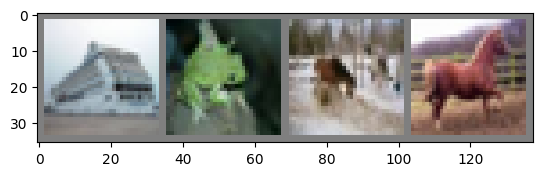

ship frog horse horse


In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
# print(dataiter)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [7]:
next(iter(train_loader))[0].shape

torch.Size([64, 3, 32, 32])

In [8]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.long_model = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32)
        )
        self.short_model = nn.Conv2d(3, 32, 1)

        self.result = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8),
            nn.Flatten(),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):
        out = self.result(self.long_model(x) + self.short_model(x))
        return out

In [ ]:
net = BasicBlockNet()
net

BasicBlockNet(
  (long_model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (short_model): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (result): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

Проверим, что выход сети имеет корректную размерность:

In [ ]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [10]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [11]:
net = net.to(device)

NameError: name 'net' is not defined

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [13]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    loss_fn = nn.CrossEntropyLoss()

    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        output = model(data)
        loss = loss_fn(output, target)
        loss_log.append(loss.item())

        target_pred = torch.argmax(output, 1)
        total = target.shape[0]
        correct = (target_pred == target).sum()
        acc = correct/total

        acc_log.append(acc.item())
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    loss_fn = nn.CrossEntropyLoss()

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()

        output = model(data)
        loss = loss_fn(output, target)
        loss_log.append(loss.item())

        loss.backward()
        optimizer.step()

        target_pred = torch.argmax(output, 1)
        total = target.shape[0]
        correct = (target_pred == target).sum()
        acc = correct/total
        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4650280603107195, train acc: 0.4777112170590779
 val loss: 1.3138727621829256, val acc: 0.5444592199427016

Epoch 1
 train loss: 1.1510095039494947, train acc: 0.593790807061483
 val loss: 1.1500600827501175, val acc: 0.604720744680851

Epoch 2
 train loss: 1.038500690155099, train acc: 0.636691205353362
 val loss: 0.9967108863465329, val acc: 0.6523936170212766

Epoch 3
 train loss: 0.9803853220216099, train acc: 0.6580699921961894
 val loss: 0.9750233026261025, val acc: 0.6648492909492331

Epoch 4
 train loss: 0.9490671287506982, train acc: 0.6681125947500713
 val loss: 0.9626553142324407, val acc: 0.6598182624958931

Epoch 5
 train loss: 0.9103820277088521, train acc: 0.6829132933503314
 val loss: 1.0110192681880708, val acc: 0.6577349292471054

Epoch 6
 train loss: 0.8861881818152433, train acc: 0.6933843693959866
 val loss: 0.9102643690210708, val acc: 0.684751773134191

Epoch 7
 train loss: 0.8648268876280601, train acc: 0.7019742426532278
 val loss: 0.9193

Посчитайте точность на тестовой выборке:

In [ ]:
total = 0
correct = 0
net.eval()

for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)

    output = net(data)

    target_pred = torch.argmax(output, 1)
    total += target.shape[0]
    correct += (target_pred == target).sum()
print((correct/total).item())

0.7058999538421631


Получили accuracy 70.6 процентов

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

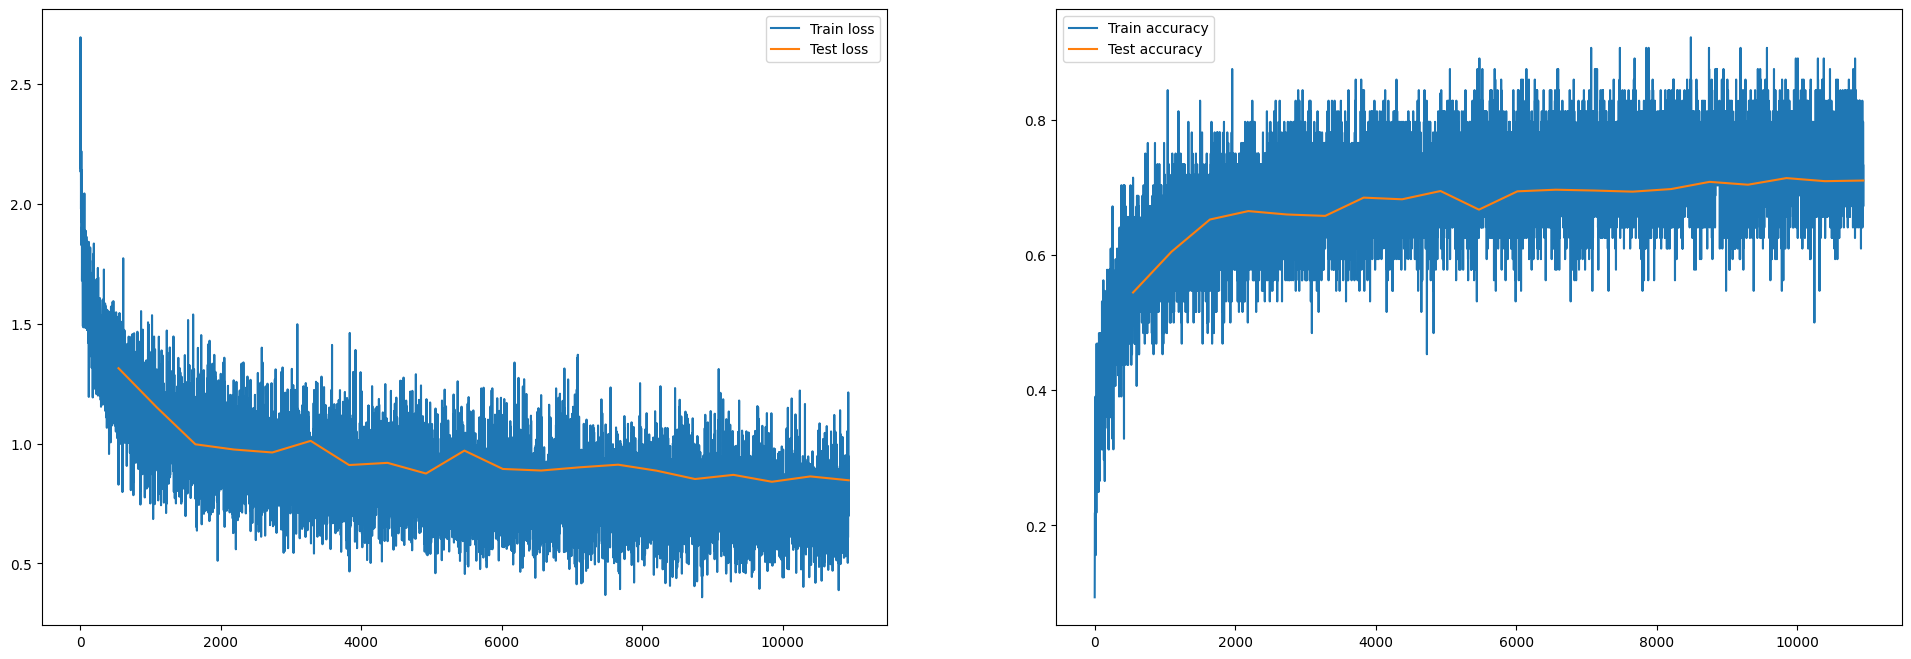

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

train_x = np.arange(1, len(train_loss_log) + 1)
val_x = np.arange(1, len(val_loss_log) + 1)*len(train_loss_log)//len(val_loss_log)

axs[0].plot(train_x, train_loss_log, label='Train loss')
axs[0].plot(val_x, val_loss_log, label='Test loss')

axs[1].plot(train_x, train_acc_log, label='Train accuracy')
axs[1].plot(val_x, val_acc_log, label='Test accuracy')

axs[0].legend()
axs[1].legend()

plt.show()

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4991354523890632, train acc: 0.4626248694643024
 val loss: 1.3604982097098168, val acc: 0.5300088654173182

Epoch 1
 train loss: 1.187832339154301, train acc: 0.5877513711151737
 val loss: 1.1360731464751224, val acc: 0.6045434397585848

Epoch 2
 train loss: 1.0665108681378896, train acc: 0.6306925764685357
 val loss: 1.0377420384833154, val acc: 0.6411125888215735

Epoch 3
 train loss: 1.0107073612797195, train acc: 0.6484477017653708
 val loss: 1.046030642631206, val acc: 0.6352171986661059

Epoch 4
 train loss: 0.972650982017273, train acc: 0.6617303800103433
 val loss: 1.0145319548059017, val acc: 0.6515514186088075

Epoch 5
 train loss: 0.9513857246970782, train acc: 0.6708589057817755
 val loss: 1.014965873829862, val acc: 0.6480496454746165

Epoch 6
 train loss: 0.9188336961012218, train acc: 0.6804240664136911
 val loss: 0.975214536900216, val acc: 0.661192376055616

Epoch 7
 train loss: 0.9062159221612557, train acc: 0.6842068751943613
 val loss: 1.01016

Посчитайте точность на тестовой выборке:

In [ ]:
total = 0
correct = 0
net.eval()

for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)

    output = net(data)

    target_pred = torch.argmax(output, 1)
    total += target.shape[0]
    correct += (target_pred == target).sum()
print((correct/total).item())

0.7085999846458435


Немного улучшили (0.2 процента), но не то, чтобы это прям что-то серьезное

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.8301066277885785, train acc: 0.362047858495381
 val loss: 1.6224169736212872, val acc: 0.43459663124794656

Epoch 1
 train loss: 1.5390109697687124, train acc: 0.4608252807988545
 val loss: 1.4502387082323116, val acc: 0.48792109933305294

Epoch 2
 train loss: 1.415714030509893, train acc: 0.4998000457038391
 val loss: 1.3674030405409792, val acc: 0.51875

Epoch 3
 train loss: 1.3447955421817368, train acc: 0.5291729238177131
 val loss: 1.3194969831629002, val acc: 0.5387411348363187

Epoch 4
 train loss: 1.2910354973193279, train acc: 0.5455202076727119
 val loss: 1.262459384380503, val acc: 0.5507092199427016

Epoch 5
 train loss: 1.2402832149587557, train acc: 0.5663276965265083
 val loss: 1.2341726592246522, val acc: 0.5674202127659574

Epoch 6
 train loss: 1.1976794271408095, train acc: 0.5811120723893481
 val loss: 1.1766120149734172, val acc: 0.5872562057160317

Epoch 7
 train loss: 1.1615897889982847, train acc: 0.5955169430816414
 val loss: 1.13691153272

In [ ]:
total = 0
correct = 0
net.eval()

for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)

    output = net(data)

    target_pred = torch.argmax(output, 1)
    total += target.shape[0]
    correct += (target_pred == target).sum()
print((correct/total).item())

0.6507999897003174


Сделали хуже на 5 процентов примерно

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

Интуитивно сходимость градиентного спуска должна быть экспоненциальной, если мы начнем снижать шаг также экспоненциально - это может помочь (будем уменьшена до 90% lr с каждой эпохой)

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4672887969278547, train acc: 0.4796617915904936
 val loss: 1.2577427164037176, val acc: 0.5544326241980208

Epoch 1
 train loss: 1.140705664480408, train acc: 0.6025439083467236
 val loss: 1.1162960394899897, val acc: 0.6128102837724888

Epoch 2
 train loss: 1.033464521551045, train acc: 0.6397884565471949
 val loss: 1.0205612758372693, val acc: 0.6473847518575953

Epoch 3
 train loss: 0.97603591715396, train acc: 0.6611590820213122
 val loss: 1.0097078571928308, val acc: 0.6505319148936171

Epoch 4
 train loss: 0.9336597644868673, train acc: 0.672168810472192
 val loss: 0.9799871731311717, val acc: 0.6603058510638298

Epoch 5
 train loss: 0.9010806657932359, train acc: 0.686724667030453
 val loss: 0.9497016138218819, val acc: 0.6694813829787234

Epoch 6
 train loss: 0.8771215640212762, train acc: 0.6970121116263339
 val loss: 0.950741241840606, val acc: 0.6665115249917862

Epoch 7
 train loss: 0.8552150273017953, train acc: 0.7034718595867401
 val loss: 0.918816

In [ ]:
total = 0
correct = 0
net.eval()

for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)

    output = net(data)

    target_pred = torch.argmax(output, 1)
    total += target.shape[0]
    correct += (target_pred == target).sum()
print((correct/total).item())

0.7109999656677246


Чуть-чуть улучшили (примерно на 0.5 процента (в другие запуски был прирост 1.5 процента, но суть примерно такая же)). Теперь используем CosineAnnealingWarmRestarts, которая меняет lr по косинусу, и которая позволяет периодически "перезапускать" lr:

In [14]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=0)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4914122207509097, train acc: 0.46386132150942927
 val loss: 1.2573967456817627, val acc: 0.5561170212765958

Epoch 1
 train loss: 1.1621891410520788, train acc: 0.5947987399109974
 val loss: 1.1133182107134068, val acc: 0.6127216312479465

Epoch 2
 train loss: 1.041992772322904, train acc: 0.6357608057245258
 val loss: 1.0699725701453837, val acc: 0.628413120736467

Epoch 3
 train loss: 0.9695722623106766, train acc: 0.6637870527708553
 val loss: 1.0422825978157368, val acc: 0.6360372340425532

Epoch 4
 train loss: 0.9201683268032737, train acc: 0.6798160421564985
 val loss: 0.9300715339944717, val acc: 0.6824689718002969

Epoch 5
 train loss: 0.8753386628039358, train acc: 0.6950615369859517
 val loss: 0.9463587796434443, val acc: 0.6717863476022761

Epoch 6
 train loss: 0.8394451759197158, train acc: 0.7084788783594721
 val loss: 0.8645983744174877, val acc: 0.7045877659574468

Epoch 7
 train loss: 0.8029908507898913, train acc: 0.7226837947556044
 val loss: 0.

In [15]:
total = 0
correct = 0
net.eval()

for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)

    output = net(data)

    target_pred = torch.argmax(output, 1)
    total += target.shape[0]
    correct += (target_pred == target).sum()
print((correct/total).item())

0.6789999604225159


Мы получили хуже на 2 процента примерно. Для нашей задачи косинус, видимо, немного странный, не подходит

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

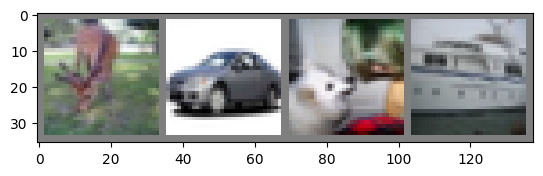

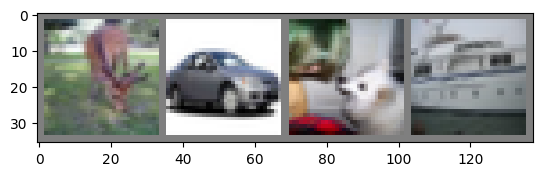

In [16]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [17]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4832900261312343, train acc: 0.47167586190609
 val loss: 1.2721043153012053, val acc: 0.5464760638297872

Epoch 1
 train loss: 1.1832571223623356, train acc: 0.5839726430188585
 val loss: 1.1172620253360017, val acc: 0.6096852837724889

Epoch 2
 train loss: 1.0583652002937833, train acc: 0.6293949138311843
 val loss: 1.074311767233179, val acc: 0.6276374114320633

Epoch 3
 train loss: 0.998555228195853, train acc: 0.651238900542913
 val loss: 0.9805749038432506, val acc: 0.6643838654173181

Epoch 4
 train loss: 0.9566417659004602, train acc: 0.6675045703839122
 val loss: 1.0000507793527968, val acc: 0.6500443263256803

Epoch 5
 train loss: 0.9198076057041803, train acc: 0.6802485963326268
 val loss: 0.9385238239105712, val acc: 0.6663342199427016

Epoch 6
 train loss: 0.904297654763872, train acc: 0.6887160486233518
 val loss: 0.9577547839347352, val acc: 0.6662898936170213

Epoch 7
 trai

Посчитайте точность на тестовой выборке:

In [18]:
total = 0
correct = 0
net.eval()

for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)

    output = net(data)

    target_pred = torch.argmax(output, 1)
    total += target.shape[0]
    correct += (target_pred == target).sum()
print((correct/total).item())

0.7292999625205994


Подняли accuracy на 2 процента - это неплохо

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

Добавил случайное аффинное преобразование к горизонтальным поворотам:

In [19]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomAffine(degrees=(30, 50), translate=(0.1, 0.2), scale=(0.5, 0.75)),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.878033446655413, train acc: 0.3120307195557101
 val loss: 1.7177331990384042, val acc: 0.3612810284533399

Epoch 1
 train loss: 1.6669102118263732, train acc: 0.39049849834912875
 val loss: 1.6019989698491197, val acc: 0.4137854610351806

Epoch 2
 train loss: 1.5720246284927704, train acc: 0.42809806739608375
 val loss: 1.5942560784360196, val acc: 0.42737145398525483

Epoch 3
 train loss: 1.5039709562357426, train acc: 0.45580193917973605
 val loss: 1.4956235966783888, val acc: 0.4647828014607125

Epoch 4
 train loss: 1.4576464693114788, train acc: 0.4726429877486046
 val loss: 1.4702769593989595, val acc: 0.46063829787234045

Epoch 5
 train loss: 1.412317524553435, train acc: 0.49525414600668705
 val loss: 1.3832080176536072, val acc: 0.5065602837724889

Epoch 6
 train loss: 1.3771044396177288, train acc: 0.509536595732464
 val loss: 1.3385269621585278, val acc: 0.513563829787234

Epoch

In [20]:
total = 0
correct = 0
net.eval()
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)

    output = net(data)

    target_pred = torch.argmax(output, 1)
    total += target.shape[0]
    correct += (target_pred == target).sum()
print((correct/total).item())

0.3255999982357025


Случайные аффинные преобразования ужасно сказались на accuracy

The ColorJitter transform randomly changes the brightness, saturation, and other properties of an image. (с документации torch) -  добавим к горизонтальным поворотам случаные изменения яркости и насыщенности:

In [21]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ColorJitter(brightness=.5, hue=.3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6683768997244686, train acc: 0.40822505885547866
 val loss: 1.4692046327793853, val acc: 0.4784796099713508

Epoch 1
 train loss: 1.3188072997647622, train acc: 0.5420720162077839
 val loss: 1.246455139048556, val acc: 0.5611258865670955

Epoch 2
 train loss: 1.2004466023044134, train acc: 0.5855477931730491
 val loss: 1.2321122587995326, val acc: 0.5785904255319149

Epoch 3
 train loss: 1.1428665840211691, train acc: 0.6075264430133255
 val loss: 1.1166351840851154, val acc: 0.6170212765957447

Epoch 4
 train loss: 1.1033648001864362, train acc: 0.6213151279707495
 val loss: 1.0953611589492636, val acc: 0.6204122340425532

Epoch 5
 train loss: 1.0793087429058834, train acc: 0.6293867524624742
 val loss: 1.0913642084344906, val acc: 0.6252216313747649

Epoch 6
 train loss: 1.0579847547428263, train acc: 0.637678734672135
 val loss: 1.0596250879003646, val acc: 0.6355939718002969

Epoch 7


In [22]:
total = 0
correct = 0
net.eval()

for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)

    output = net(data)

    target_pred = torch.argmax(output, 1)
    total += target.shape[0]
    correct += (target_pred == target).sum()
print((correct/total).item())

0.7001999616622925


Получили примерно столько же, с чего начинали. Выходит, что для конкретно этой задачи лучше всего только горизонтальные повороты

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>